<img src="mioti.png" style="height: 100px">
<center style="color:#888">Módulo Data Science in IoT<br/>Asignatura Data Visualization</center>

# Challenge S3: Prophet 
# Planificación de escenarios a futuro post-confinamiento en Retail

Tenemos las ventas de todas las tiendas de una cadena de retail en una serie de categorías desde principios de 2018 hasta que acabó el confinamiento estricto y queremos hacer un análisis del impacto que ha tenido en las distintas categorías y plantear escenarios a futuro en caso de haber alguna vuelta al confinamiento.

Teniendo esta valiosa información podríamos mejorar el stockage de los productos de las distintas categorías y poder reaccionar rápido en cuanto se anunciasen las nuevas medidas para poder amoldar espacios en los distintos almacenes de las tiendas y los pedidos en las distintas categorías en base a los distintos escenarios que podamos proponer.

In [2]:
import pandas as pd
import numpy as np
from fbprophet import Prophet
import matplotlib.pyplot as plt
%matplotlib inline

## 1. Cargar las ventas en un DataFrame

In [3]:
df_datos_categorias = pd.read_csv('Tabla Ventas Cats.csv',delimiter = ';')
df_datos_categorias['Fecha'] = pd.to_datetime(df_datos_categorias['Fecha'], format='%Y-%m-%d')
df_datos_categorias.tail()

,Fecha,Categoría,Unidades,Ventas
14865,2020-05-31,Yogurt saludable,4.000,8.56
14866,2020-05-31,Papel higiénico,3.000,8.99
14867,2020-05-31,Patatas,2.000,7.18
14868,2020-05-31,Naranjas,9.475,25.25
14869,2020-05-31,Tabletas de chocolate,7.000,8.96


In [4]:
df_datos_categorias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14870 entries, 0 to 14869
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Fecha      14870 non-null  datetime64[ns]
 1   Categoría  14870 non-null  object        
 2   Unidades   14870 non-null  float64       
 3   Ventas     14870 non-null  float64       
dtypes: datetime64[ns](1), float64(2), object(1)
memory usage: 464.8+ KB


## 2. Exploración de los datos

** P. ¿ Cuál es el inicio y el final de datos ? **

In [5]:
#Los datos pertenecen a una serie temporal diaria, que se represena en la columna fecha
print('El inicio de los datos es : ',str(df_datos_categorias['Fecha'].describe(datetime_is_numeric=True).loc['min']))
print('El final de los datos es : ',str(df_datos_categorias['Fecha'].describe(datetime_is_numeric=True).loc['max']))

El inicio de los datos es :  2018-01-01 00:00:00
El final de los datos es :  2020-05-31 00:00:00


** P ¿ De qué categorías tenemos venta ? **

In [6]:
cats = df_datos_categorias['Categoría'].unique()
print('Las categorias de productos son : ',str(cats))

Las categorias de productos son :  ['Aguas sin gas' 'Cervezas con alcohol' 'Colas' 'Utensilios de cocina'
 'Frutos secos' 'Leche' 'Huevos' 'Pizza congelada' 'Pasta'
 'Caldos y cremas líquidas' 'Yogurt saludable' 'Barras de pan baguette'
 'Barras de pan rústico' 'Papel higiénico' 'Patatas' 'Naranjas'
 'Tabletas de chocolate']


## 3. Obtención de la mejor y peor categoría en los distintos trimestres y lo que llevamos de semestre

Vamos a obtener un dataframe con el comportamiento de las distintas categorías en cuanto a variación porcentual de ventas para el Q1, Q2 y lo que llevamos de S1, es decir hasta el 31 de Mayo.

%Var = ((Vactuales/Vanteriores) - 1 ) * 100

In [7]:
#Función que aplica la formula de la variación de las ventas.
def calculo_variaciones (column):
    resultado = ((column/column.shift(4))-1)*100 
    return resultado

In [8]:
# Lo primero que realizamos es establecer el campo fecha como indice para poder trabajar de forma más optima con el
df_categorias_trimestre = df_datos_categorias.copy()
df_categorias_trimestre = df_categorias_trimestre[((df_categorias_trimestre['Fecha'] >= '2019-01-01') &
    (df_categorias_trimestre['Fecha'] <= '2019-05-31'))|((df_categorias_trimestre['Fecha'] >= '2020-01-01') &
    (df_categorias_trimestre['Fecha'] <= '2020-05-31'))]
df_categorias_trimestre.reset_index(drop=True)

,Fecha,Categoría,Unidades,Ventas
0,2019-01-02,Aguas sin gas,17294.000,9804.197398
1,2019-01-02,Cervezas con alcohol,9273.000,8265.329593
2,2019-01-02,Colas,5207.000,5491.240018
3,2019-01-02,Utensilios de cocina,14796.550,1284.260003
4,2019-01-02,Frutos secos,2619.000,4989.990017
...,...,...,...,...
5075,2020-05-31,Yogurt saludable,4.000,8.560000
5076,2020-05-31,Papel higiénico,3.000,8.990000
5077,2020-05-31,Patatas,2.000,7.180000
5078,2020-05-31,Naranjas,9.475,25.250000


In [9]:
df_categorias_trimestre_pivot = pd.pivot_table(df_categorias_trimestre, values='Ventas', index=['Fecha'],
                     columns=['Categoría'],aggfunc='sum',fill_value=0)
df_categorias_trimestre_pivot=df_categorias_trimestre_pivot.resample('Q').sum()
#df_categorias_trimestre_pivot.pct_change()
df_categorias_trimestre_pivot=df_categorias_trimestre_pivot.apply(calculo_variaciones)
df_categorias_trimestre_pivot

Categoría,Aguas sin gas,Barras de pan baguette,Barras de pan rústico,Caldos y cremas líquidas,Cervezas con alcohol,Colas,Frutos secos,Huevos,Leche,Naranjas,Papel higiénico,Pasta,Patatas,Pizza congelada,Tabletas de chocolate,Utensilios de cocina,Yogurt saludable
Fecha,,,,,,,,,,,,,,,,,
2019-03-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-06-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-09-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-31,12.374515,-7.675047,6.468455,27.711098,19.604766,13.142911,22.690160,28.191456,15.094166,29.203064,40.846754,28.486008,25.692084,11.464366,19.314632,65.617341,13.561464
2020-06-30,10.302379,-29.422162,-5.280913,21.156058,51.762760,23.053151,50.495376,42.172560,21.485315,110.698487,12.009556,11.990177,28.779281,16.929898,44.977860,52.178302,17.907836


In [10]:
df_categorias_trimestre_definitivo=df_categorias_trimestre_pivot.T
df_categorias_trimestre_definitivo

Fecha,2019-03-31,2019-06-30,2019-09-30,2019-12-31,2020-03-31,2020-06-30
Categoría,,,,,,
Aguas sin gas,NaN,NaN,NaN,NaN,12.374515,10.302379
Barras de pan baguette,NaN,NaN,NaN,NaN,-7.675047,-29.422162
Barras de pan rústico,NaN,NaN,NaN,NaN,6.468455,-5.280913
Caldos y cremas líquidas,NaN,NaN,NaN,NaN,27.711098,21.156058
Cervezas con alcohol,NaN,NaN,NaN,NaN,19.604766,51.762760
Colas,NaN,NaN,NaN,NaN,13.142911,23.053151
Frutos secos,NaN,NaN,NaN,NaN,22.690160,50.495376
Huevos,NaN,NaN,NaN,NaN,28.191456,42.172560
Leche,NaN,NaN,NaN,NaN,15.094166,21.485315


In [11]:

df_categorias_trimestre_definitivo['Q1_19_20']=df_categorias_trimestre_definitivo.iloc[:,4]
df_categorias_trimestre_definitivo['Q2_19_20']=df_categorias_trimestre_definitivo.iloc[:,5]

df_categorias_trimestre_definitivo=df_categorias_trimestre_definitivo.loc[:,['Q1_19_20','Q2_19_20']]#,'S_20']]
#df_categorias_trimestre_definitivo['S1_19_20']=
df_categorias_trimestre_definitivo.sort_values(by='Q2_19_20', ascending=False)


Fecha,Q1_19_20,Q2_19_20
Categoría,,
Naranjas,29.203064,110.698487
Utensilios de cocina,65.617341,52.178302
Cervezas con alcohol,19.604766,51.762760
Frutos secos,22.690160,50.495376
Tabletas de chocolate,19.314632,44.977860
Huevos,28.191456,42.172560
Patatas,25.692084,28.779281
Colas,13.142911,23.053151
Leche,15.094166,21.485315


In [193]:
(29.203064 + 110.698487)/2

69.9507755

In [11]:
#Calculo del S1

In [179]:
#Función que aplica la formula de la variación de las ventas.
def calculo_variaciones_seis (column):
    resultado = ((column/column.shift(4))-1)*100 
    return resultado

In [184]:
df_categorias_semestre = df_datos_categorias.copy()
df_categorias_semestre = df_categorias_semestre[((df_categorias_semestre['Fecha'] >= '2019-01-01') &
    (df_categorias_semestre['Fecha'] <= '2019-05-31'))|((df_categorias_semestre['Fecha'] >= '2020-01-01') &
    (df_categorias_semestre['Fecha'] <= '2020-05-31'))]
df_categorias_semestre.reset_index(drop=True)

df_categorias_semestre_pivot = pd.pivot_table(df_categorias_semestre, values='Ventas', index=['Fecha'],
                     columns=['Categoría'],aggfunc='sum',fill_value=0)
df_categorias_semestre_pivot=df_categorias_semestre_pivot.resample('5MS').sum()
# #df_categorias_trimestre_pivot.pct_change()
#df_categorias_semestre_pivot=df_categorias_semestre_pivot.apply(calculo_variaciones_seis)
df_categorias_semestre_pivot

Categoría,Aguas sin gas,Barras de pan baguette,Barras de pan rústico,Caldos y cremas líquidas,Cervezas con alcohol,Colas,Frutos secos,Huevos,Leche,Naranjas,Papel higiénico,Pasta,Patatas,Pizza congelada,Tabletas de chocolate,Utensilios de cocina,Yogurt saludable
Fecha,,,,,,,,,,,,,,,,,
2019-01-01,1.313572e+06,466777.954007,463344.120441,632389.609792,1.456668e+06,830388.523156,784172.210431,708366.091144,1.185843e+06,614415.521172,437232.146715,327837.725352,614603.114774,575669.277371,527593.342028,177389.502938,1.000909e+06
2019-06-01,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00
2019-11-01,8.725569e+05,263281.312145,301446.149342,508167.450737,9.917613e+05,549116.765949,571712.980812,534872.902212,8.326729e+05,475417.828576,369809.925786,262770.942536,443707.190242,397604.527981,373494.330652,169592.691637,6.805943e+05
2020-04-01,5.924337e+05,128176.310927,170695.379696,284093.630278,9.522638e+05,424605.087285,478862.880106,413893.796794,5.617146e+05,519274.410389,195647.357678,138111.271351,336876.130268,256028.872845,311064.800294,114117.260999,4.735073e+05


In [175]:
df_categorias_semestre_definitivo=df_categorias_semestre_pivot.T
df_categorias_semestre_definitivo

Fecha,2019-01-31,2019-07-31,2020-01-31,2020-07-31
Categoría,,,,
Aguas sin gas,NaN,NaN,0.211725,14.314096
Barras de pan baguette,NaN,NaN,-11.412988,-17.371864
Barras de pan rústico,NaN,NaN,-1.776065,2.871910
Caldos y cremas líquidas,NaN,NaN,2.691392,32.817616
Cervezas con alcohol,NaN,NaN,11.750781,37.914248
Colas,NaN,NaN,5.669701,19.880163
Frutos secos,NaN,NaN,3.748911,40.737296
Huevos,NaN,NaN,9.906697,40.060801
Leche,NaN,NaN,-3.660991,23.746611


In [15]:
df_categorias_semestre_definitivo['S1_19_20']=df_categorias_semestre_definitivo.iloc[:,3]
df_categorias_semestre_definitivo=df_categorias_semestre_definitivo.loc[:,'S1_19_20']
# df_categorias_semestre_definitivo.sort_values(by='S1_19_20', ascending=False)
df_categorias_semestre_definitivo.sort_values(ascending=False)

Categoría
Naranjas                    78.207029
Utensilios de cocina        61.545096
Frutos secos                40.737296
Huevos                      40.060801
Cervezas con alcohol        37.914248
Tabletas de chocolate       35.700127
Papel higiénico             35.392306
Patatas                     33.679920
Caldos y cremas líquidas    32.817616
Pasta                       28.391009
Leche                       23.746611
Colas                       19.880163
Yogurt saludable            19.015795
Pizza congelada             18.214340
Aguas sin gas               14.314096
Barras de pan rústico        2.871910
Barras de pan baguette     -17.371864
Name: S1_19_20, dtype: float64

## 4. Visualización de mejor y peor categoría en el S1

En función a la mejor y peor categoría en cuanto a % de variación de ventas que hayas obtenido en el apartado anterior, haz un ploteo de ambas categorías filtradas para ver cómo ha sido visualmente ese impacto y que veamos que puntos hay interesantes.

En primer lugar sería interesante plotear el primer año de ventas para ver la estacionalidad que tenía o el comportamiento normal de esta serie temporal por así decirlo y luego vamos a ver el comportamiento en lo que llevamos de 2020 para identificar anomalías.

#### Mejor categoría

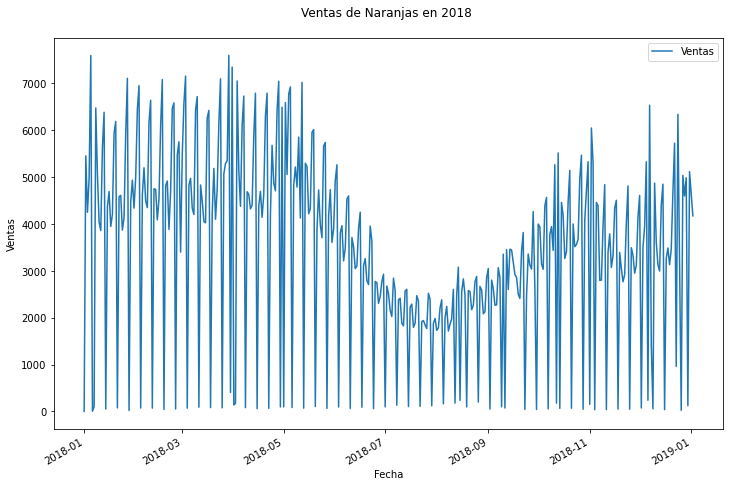

In [16]:
## Representamos nuestra serie temporal para el primer año
df_datos_categorias_mejor=df_datos_categorias[df_datos_categorias['Categoría']=='Naranjas'].loc[:,['Fecha','Ventas']].reset_index(drop=True)
ax = df_datos_categorias_mejor.iloc[:364].set_index('Fecha').plot(figsize = (12, 8),
                                      title = 'Ventas de Naranjas en 2018 \n')
ax.set_ylabel('Ventas')
ax.set_xlabel('Fecha')

plt.show()

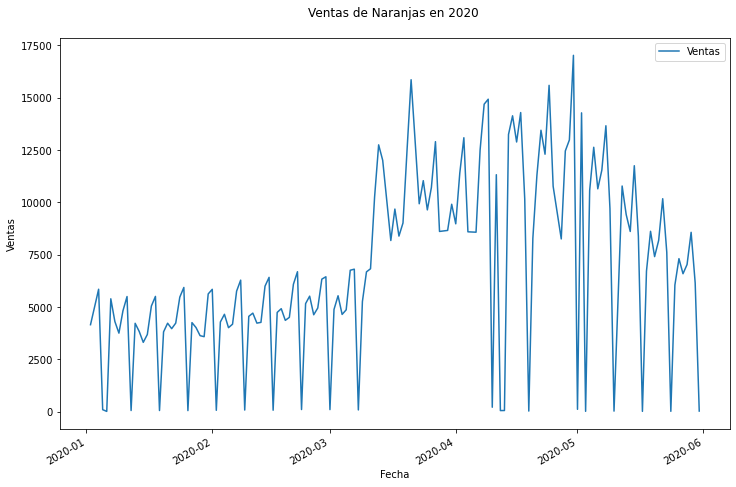

In [17]:
## Representamos nuestra serie temporal para 2020
ax = df_datos_categorias_mejor.iloc[726:].set_index('Fecha').plot(figsize = (12, 8),
                                      title = 'Ventas de Naranjas en 2020 \n')
ax.set_ylabel('Ventas')
ax.set_xlabel('Fecha')

plt.show()


#### Peor categoría

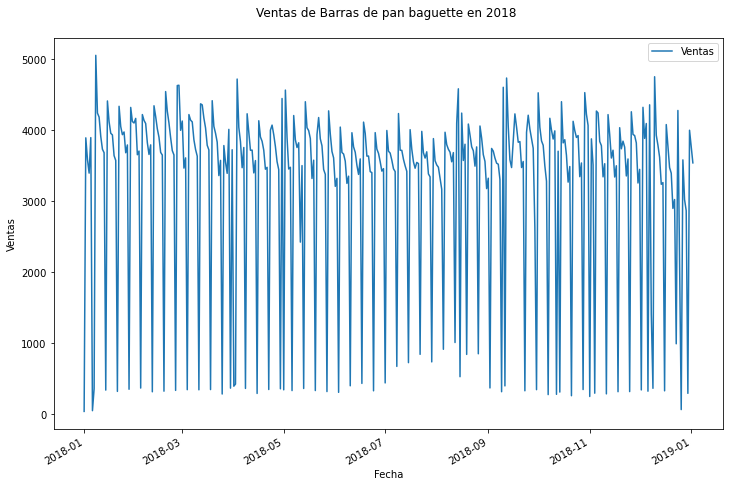

In [18]:
## Representamos nuestra serie temporal para el primer año
df_datos_categorias_peor=df_datos_categorias[df_datos_categorias['Categoría']=='Barras de pan baguette'].loc[:,['Fecha','Ventas']].reset_index(drop=True)
ax = df_datos_categorias_peor.iloc[:364].set_index('Fecha').plot(figsize = (12, 8),
                                      title = 'Ventas de Barras de pan baguette en 2018 \n')
ax.set_ylabel('Ventas')
ax.set_xlabel('Fecha')

plt.show()

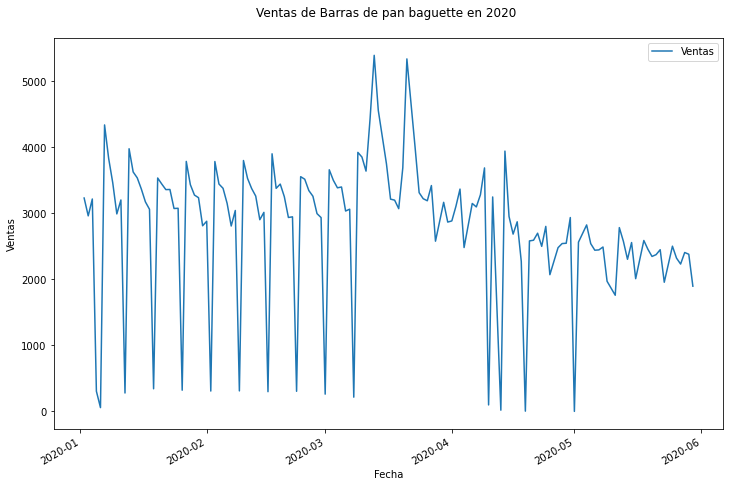

In [19]:
## Representamos nuestra serie temporal para 2020
ax = df_datos_categorias_peor.iloc[726:].set_index('Fecha').plot(figsize = (12, 8),
                                      title = 'Ventas de Barras de pan baguette en 2020 \n')
ax.set_ylabel('Ventas')
ax.set_xlabel('Fecha')

plt.show()

## 5. Realizar una previsión simple sobre las ventas en 2021

En este primer paso se trata de realizar una primera predicción de las ventas de una categoría en concreto hasta el final de 2021, vamos a ver como reacciona el modelo sin añadir ningún tipo de holiday para ver la interpretación del mismo cuando no le damos ningún otro tipo de input.

Para una primera aproximación vamos a coger la categoría con mejor evolución de ventas.

In [20]:
#Preparamos el dataframe para Prophet
df_datos_categorias_mejor=df_datos_categorias[df_datos_categorias['Categoría']=='Naranjas'].loc[:,['Fecha','Ventas']].reset_index(drop=True)
df_datos_categorias_mejor = df_datos_categorias_mejor.rename(columns={'Fecha': 'ds', 'Ventas': 'y'})
df_datos_categorias_mejor

,ds,y
0,2018-01-01,1.890000
1,2018-01-02,5454.980826
2,2018-01-03,4249.981477
3,2018-01-04,4981.092628
4,2018-01-05,7594.093859
...,...,...
867,2020-05-27,6586.670017
868,2020-05-28,7026.790011
869,2020-05-29,8565.650021
870,2020-05-30,6147.320011


In [21]:
modelo = Prophet(daily_seasonality=True)
modelo.fit(df_datos_categorias_mejor)
futuro = modelo.make_future_dataframe(periods=579)
futuro.tail()

,ds
1446,2021-12-27
1447,2021-12-28
1448,2021-12-29
1449,2021-12-30
1450,2021-12-31


In [22]:
prevision = modelo.predict(futuro)
prevision.tail()


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
1446,2021-12-27,18241.115587,18058.555187,24158.289828,15987.682799,20611.607015,2942.231056,2942.231056,2942.231056,2897.5089,...,115.191173,115.191173,115.191173,-70.469017,-70.469017,-70.469017,0.0,0.0,0.0,21183.346643
1447,2021-12-28,18264.559669,18746.750797,24691.493507,16007.101235,20636.089854,3450.264809,3450.264809,3450.264809,2897.5089,...,598.619436,598.619436,598.619436,-45.863527,-45.863527,-45.863527,0.0,0.0,0.0,21714.824477
1448,2021-12-29,18288.003751,18348.635061,24288.348923,16024.038386,20660.572692,2969.846987,2969.846987,2969.846987,2897.5089,...,93.222278,93.222278,93.222278,-20.884191,-20.884191,-20.884191,0.0,0.0,0.0,21257.850738
1449,2021-12-30,18311.447832,18612.172601,24507.796695,16037.412882,20686.677937,3204.774776,3204.774776,3204.774776,2897.5089,...,303.195128,303.195128,303.195128,4.070748,4.070748,4.070748,0.0,0.0,0.0,21516.222608
1450,2021-12-31,18334.891914,19282.225557,25307.176647,16050.781129,20717.160535,4056.346933,4056.346933,4056.346933,2897.5089,...,1130.233014,1130.233014,1130.233014,28.605018,28.605018,28.605018,0.0,0.0,0.0,22391.238847


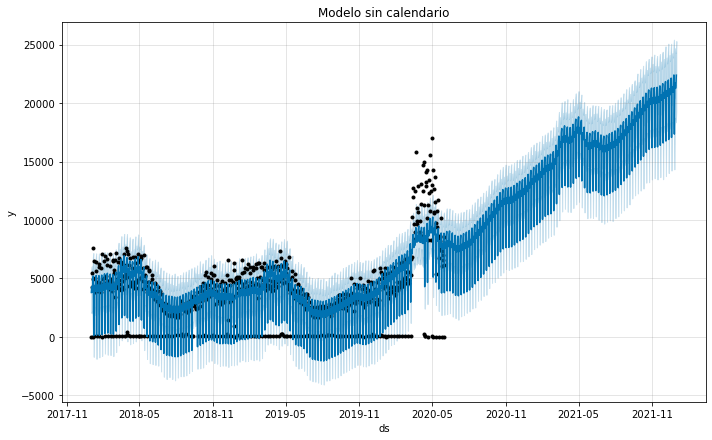

In [169]:
modelo.plot(prevision);
plt.gca().set_title('Modelo sin calendario');

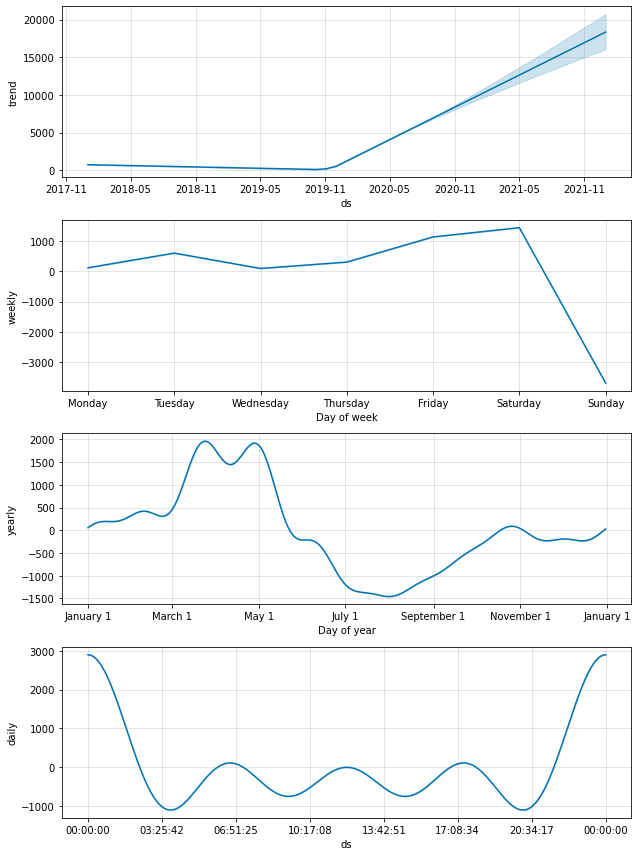

In [24]:
modelo.plot_components(prevision, weekly_start = 1);

** P ¿ Están bien nuestras predicciones ? ** Fíjate en la estacionalidad anual donde presenta un pico, ¿ ha habido alguna influencia puntual que haya podido influenciar en este cálculo ?

## 6. Mejorar nuestro modelo de previsión incluyendo algún evento especial.

Incluya una lista de holidays que sea interesante con sus distintos tags para que el modelo separe mejor que contribuciones vienen por la propia estacionalidad o por eventos externos.

Tener en cuenta todo este tipo de eventos sólo en el ámbito temporal de entrenamiento (del que tenemos datos), no lo proyectéis a futuro aún.


In [133]:
# Confinamiento COVID https://es.wikipedia.org/wiki/Confinamiento_por_la_pandemia_de_COVID-19_en_Espa%C3%B1a

#En 2020 no consideramos dias especiales de semana santa ya que se incluye dentro del periodo de confinamiento.
semanasanta = pd.DataFrame({
  'holiday': 'semanasanta',
  'ds': pd.to_datetime(['2018-03-28','2018-03-29', '2018-03-30',
                        '2018-04-01','2018-04-02', '2019-04-18',
                        '2019-04-19','2019-04-20', '2019-04-21',
                        '2019-04-22']),
  'lower_window': 0,
  'upper_window': 1,
})

confinamiento = pd.DataFrame({
  'holiday': 'confinamiento',
  'ds': pd.to_datetime(['2020-03-15', '2020-03-16', '2020-03-17', '2020-03-18',
               '2020-03-19', '2020-03-20', '2020-03-21', '2020-03-22',
               '2020-03-23', '2020-03-24', '2020-03-25', '2020-03-26',
               '2020-03-27', '2020-03-28', '2020-03-29', '2020-03-30',
               '2020-03-31', '2020-04-01', '2020-04-02', '2020-04-03',
               '2020-04-04', '2020-04-05', '2020-04-06', '2020-04-07',
               '2020-04-08', '2020-04-09', '2020-04-10', '2020-04-11',
               '2020-04-12', '2020-04-13', '2020-04-14', '2020-04-15',
               '2020-04-16', '2020-04-17', '2020-04-18', '2020-04-19',
               '2020-04-20', '2020-04-21', '2020-04-22', '2020-04-23',
               '2020-04-24', '2020-04-25', '2020-04-26', '2020-04-27',
               '2020-04-28', '2020-04-29', '2020-04-30', '2020-05-01',
               '2020-05-02', '2020-05-03', '2020-05-04', '2020-05-05',
               '2020-05-06', '2020-05-07', '2020-05-08', '2020-05-09',
               '2020-05-10', '2020-05-11', '2020-05-12', '2020-05-13',
               '2020-05-14', '2020-05-15', '2020-05-16', '2020-05-17',
               '2020-05-18', '2020-05-19', '2020-05-20', '2020-05-21',
               '2020-05-22', '2020-05-23', '2020-05-24', '2020-05-25',
               '2020-05-26', '2020-05-27', '2020-05-28', '2020-05-29',
               '2020-05-30', '2020-05-31', '2020-06-01', '2020-06-02',
               '2020-06-03', '2020-06-04', '2020-06-05', '2020-06-06',
               '2020-06-07', '2020-06-08', '2020-06-09', '2020-06-10',
               '2020-06-11', '2020-06-12', '2020-06-13', '2020-06-14',
               '2020-06-15', '2020-06-16', '2020-06-17', '2020-06-18',
               '2020-06-19', '2020-06-20', '2020-06-21']),
  'lower_window': 0,
  'upper_window': 1,
})


cierres_perimterales_puente_dic_2020 = pd.DataFrame({
  'holiday': 'cierres',
  'ds': pd.to_datetime(['2020-12-01', '2020-12-02', '2020-12-03', '2020-12-04',
               '2020-12-05', '2020-12-06', '2020-12-07', '2020-12-08',
               '2020-12-09', '2020-12-10', '2020-12-11', '2020-12-12',
               '2020-12-13', '2020-12-14', '2020-12-15']),
  'lower_window': 0,
  'upper_window': 1,
})

semanasanta_2021 = pd.DataFrame({
  'holiday': 'semanasanta',
  'ds': pd.to_datetime(['2021-04-01', '2021-04-02', '2021-04-03', '2021-04-04','2021-04-05']),
  'lower_window': 0,
  'upper_window': 1,
})


In [26]:
pd.date_range(start='2020-12-01', end='2020-12-15')

DatetimeIndex(['2020-12-01', '2020-12-02', '2020-12-03', '2020-12-04',
               '2020-12-05', '2020-12-06', '2020-12-07', '2020-12-08',
               '2020-12-09', '2020-12-10', '2020-12-11', '2020-12-12',
               '2020-12-13', '2020-12-14', '2020-12-15'],
              dtype='datetime64[ns]', freq='D')

In [134]:
dias_especiales = pd.concat((semanasanta, confinamiento,cierres_perimterales_puente_dic_2020,semanasanta_2021))
dias_especiales

,holiday,ds,lower_window,upper_window
0,semanasanta,2018-03-28,0,1
1,semanasanta,2018-03-29,0,1
2,semanasanta,2018-03-30,0,1
3,semanasanta,2018-04-01,0,1
4,semanasanta,2018-04-02,0,1
...,...,...,...,...
0,semanasanta,2021-04-01,0,1
1,semanasanta,2021-04-02,0,1
2,semanasanta,2021-04-03,0,1
3,semanasanta,2021-04-04,0,1


In [135]:
dias_especiales = dias_especiales.reset_index()
modelo2 = Prophet(holidays=dias_especiales,daily_seasonality=True)
modelo2.fit(df_datos_categorias_mejor)
futuro2 = modelo2.make_future_dataframe(periods=579)
futuro.tail()

,ds
1446,2021-12-27
1447,2021-12-28
1448,2021-12-29
1449,2021-12-30
1450,2021-12-31


In [136]:
prevision2 = modelo2.predict(futuro2)
prevision2.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,cierres,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
1446,2021-12-27,754.505005,2114.845680,5629.939789,690.241244,826.836525,3106.993259,3106.993259,3106.993259,0.0,...,105.893485,105.893485,105.893485,205.946464,205.946464,205.946464,0.0,0.0,0.0,3861.498263
1447,2021-12-28,754.786154,2618.154295,6013.206000,690.375502,827.442332,3607.405907,3607.405907,3607.405907,0.0,...,581.001480,581.001480,581.001480,231.251118,231.251118,231.251118,0.0,0.0,0.0,4362.192060
1448,2021-12-29,755.067303,2099.294753,5571.805518,690.509760,828.048139,3117.954966,3117.954966,3117.954966,0.0,...,66.172928,66.172928,66.172928,256.628729,256.628729,256.628729,0.0,0.0,0.0,3873.022268
1449,2021-12-30,755.348452,2336.302968,5925.371808,690.644018,828.612809,3380.707300,3380.707300,3380.707300,0.0,...,303.652312,303.652312,303.652312,281.901679,281.901679,281.901679,0.0,0.0,0.0,4136.055752
1450,2021-12-31,755.629601,3316.504416,6849.005482,690.778276,829.072426,4243.616173,4243.616173,4243.616173,0.0,...,1141.568334,1141.568334,1141.568334,306.894530,306.894530,306.894530,0.0,0.0,0.0,4999.245774


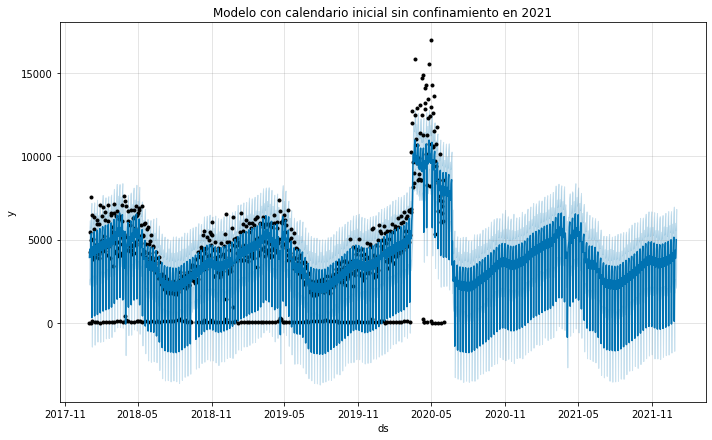

In [166]:
modelo2.plot(prevision2);
plt.gca().set_title('Modelo con calendario inicial sin confinamiento en 2021');

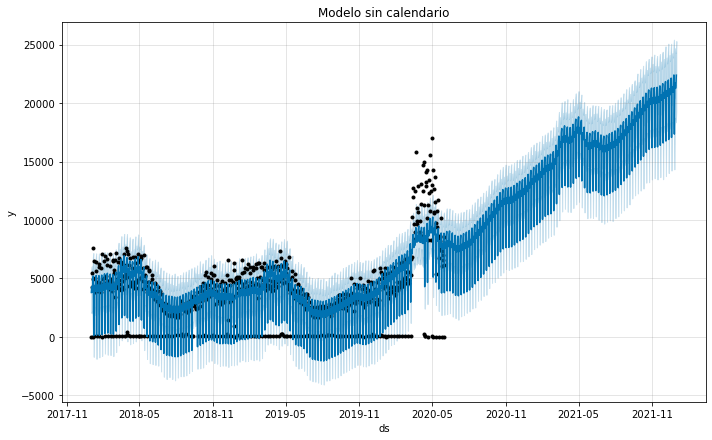

In [168]:
#Modelo anterior sin calendario
modelo.plot(prevision);
plt.gca().set_title('Modelo sin calendario');

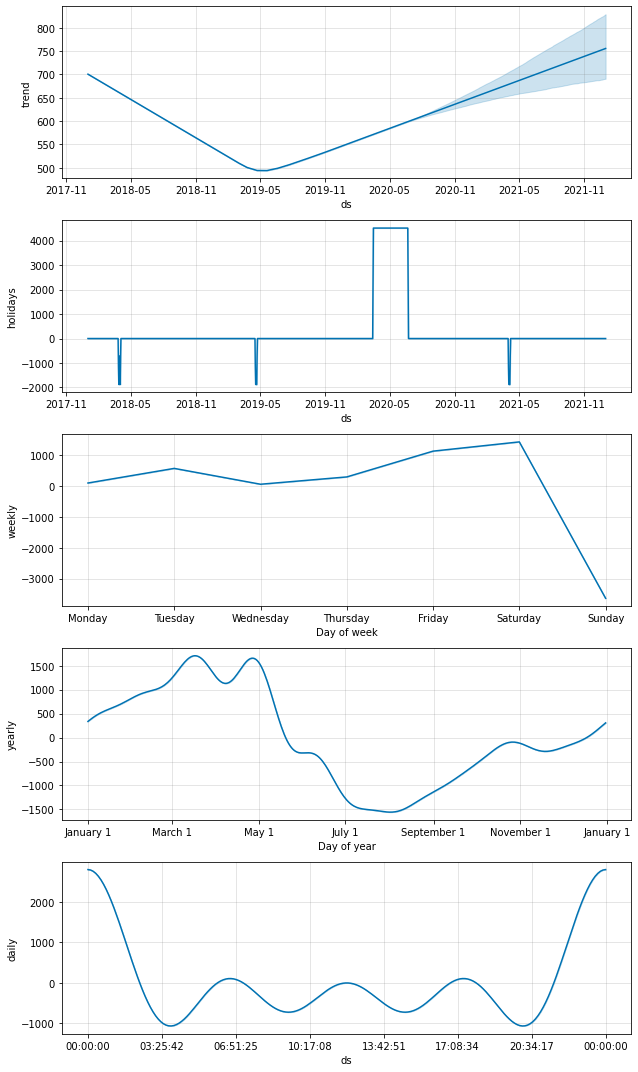

In [139]:
modelo2.plot_components(prevision2, weekly_start = 1);

## 7. Plantear distintos escenarios sobre un posible confinamiento y ver su impacto en las ventas (usando el % variación  de ventas entre trimestres)

Ya que hemos visto como el modelo se ha modificado en cuanto hemos señalado eventos externos que tenían cierta influencia sobre nuestra serie temporal se os pide que para la categoría que queráis, hagáis el entrenamiento del modelo y la predicción hasta 2021 teniendo en cuenta los efectos de todas estas variables externas y además incluirlos en vuestra predicción a futuro según distintos escenarios que tengáis en mente.

### Escenario 1 : Hay confinamiento a principios de 2021

In [140]:
# Confinamiento COVID https://es.wikipedia.org/wiki/Confinamiento_por_la_pandemia_de_COVID-19_en_Espa%C3%B1a

confinamiento_inicio_2021 = pd.DataFrame({
  'holiday': 'confinamiento',
  'ds': pd.to_datetime(['2021-01-09', '2021-01-10', '2021-01-11', '2021-01-12',
               '2021-01-13', '2021-01-14', '2021-01-15', '2021-01-16',
               '2021-01-17', '2021-01-18', '2021-01-19', '2021-01-20',
               '2021-01-21', '2021-01-22', '2021-01-23', '2021-01-24',
               '2021-01-25', '2021-01-26', '2021-01-27', '2021-01-28',
               '2021-01-29', '2021-01-30', '2021-01-31', '2021-02-01',
               '2021-02-02', '2021-02-03', '2021-02-04', '2021-02-05',
               '2021-02-06', '2021-02-07', '2021-02-08', '2021-02-09',
               '2021-02-10', '2021-02-11', '2021-02-12', '2021-02-13',
               '2021-02-14', '2021-02-15', '2021-02-16', '2021-02-17',
               '2021-02-18', '2021-02-19', '2021-02-20', '2021-02-21',
               '2021-02-22', '2021-02-23', '2021-02-24', '2021-02-25',
               '2021-02-26', '2021-02-27', '2021-02-28', '2021-03-01',
               '2021-03-02', '2021-03-03', '2021-03-04', '2021-03-05',
               '2021-03-06', '2021-03-07', '2021-03-08', '2021-03-09',
               '2021-03-10', '2021-03-11', '2021-03-12', '2021-03-13',
               '2021-03-14']),
  'lower_window': 0,
  'upper_window': 1,
})


In [112]:
#pd.date_range(start='2021-07-15', end='2021-09-15')

In [143]:
dias_especiales_incio_2021 = pd.concat((semanasanta, confinamiento,cierres_perimterales_puente_dic_2020,confinamiento_inicio_2021,semanasanta_2021))
dias_especiales_incio_2021

,holiday,ds,lower_window,upper_window
0,semanasanta,2018-03-28,0,1
1,semanasanta,2018-03-29,0,1
2,semanasanta,2018-03-30,0,1
3,semanasanta,2018-04-01,0,1
4,semanasanta,2018-04-02,0,1
...,...,...,...,...
0,semanasanta,2021-04-01,0,1
1,semanasanta,2021-04-02,0,1
2,semanasanta,2021-04-03,0,1
3,semanasanta,2021-04-04,0,1


In [144]:
dias_especiales_incio_2021 = dias_especiales_incio_2021.reset_index()

In [145]:
# modelo_2021_1 = Prophet(holidays=dias_especiales_incio_2021,daily_seasonality=True,weekly_seasonality=True)
modelo_2021_1 = Prophet(holidays=dias_especiales_incio_2021)
prevision_2021_1= modelo_2021_1.fit(df_datos_categorias_mejor)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


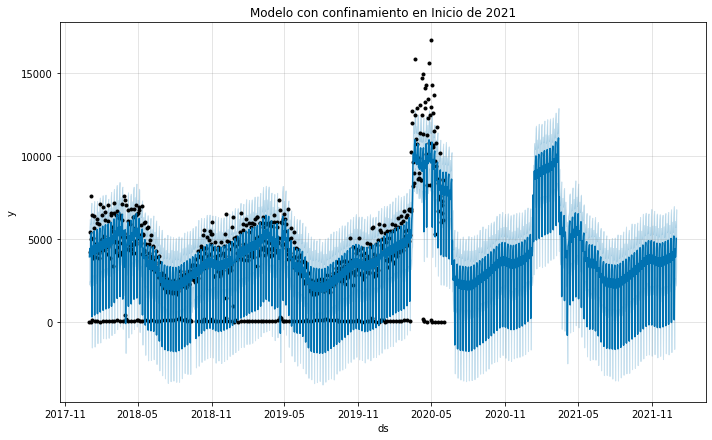

In [165]:
futuro3 = modelo_2021_1.make_future_dataframe(periods=579)
prevision_2021_1 = modelo_2021_1.predict(futuro3)
modelo_2021_1.plot(prevision_2021_1);
plt.gca().set_title('Modelo con confinamiento en Inicio de 2021');

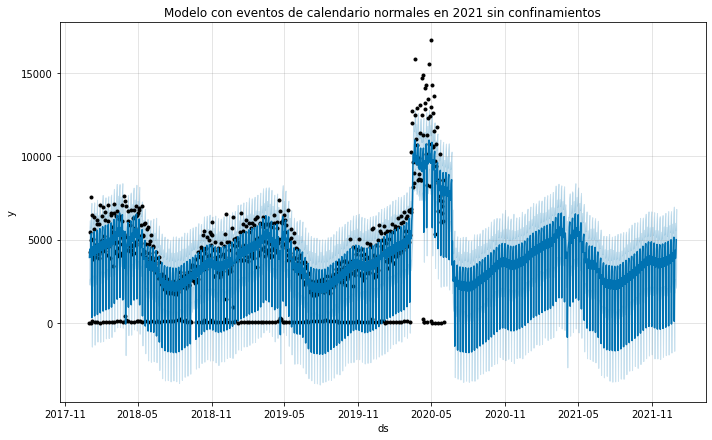

In [164]:
#Modelo con eventos de calendario normales sin confinamientos
modelo2.plot(prevision2);
plt.gca().set_title('Modelo con eventos de calendario normales en 2021 sin confinamientos');

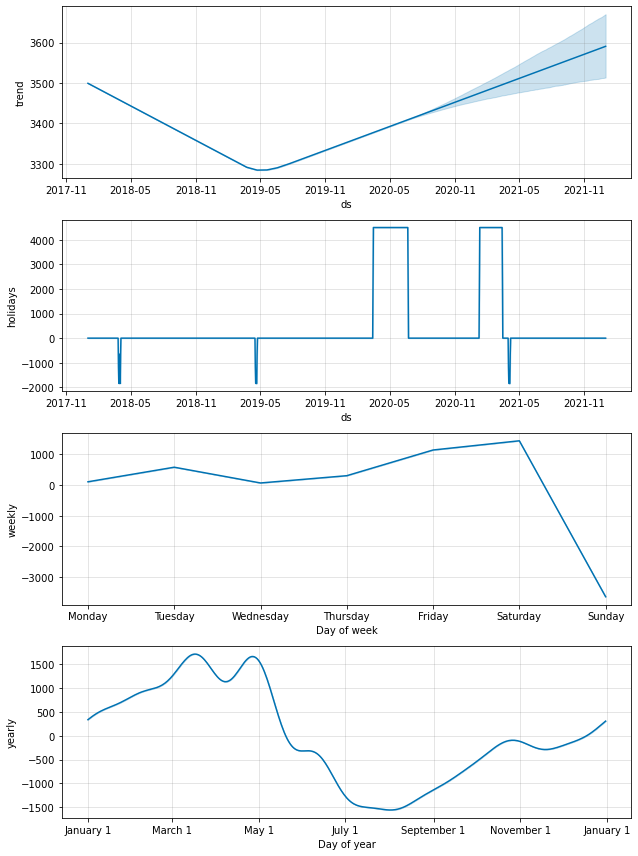

In [148]:
modelo_2021_1.plot_components(prevision_2021_1, weekly_start = 1);

### Escenario 2 : Hay confinamiento en verano de 2021 por una cepa nueva

In [149]:
confinamiento_verano_2021 = pd.DataFrame({
  'holiday': 'confinamiento',
  'ds': pd.to_datetime(['2021-07-15', '2021-07-16', '2021-07-17', '2021-07-18',
               '2021-07-19', '2021-07-20', '2021-07-21', '2021-07-22',
               '2021-07-23', '2021-07-24', '2021-07-25', '2021-07-26',
               '2021-07-27', '2021-07-28', '2021-07-29', '2021-07-30',
               '2021-07-31', '2021-08-01', '2021-08-02', '2021-08-03',
               '2021-08-04', '2021-08-05', '2021-08-06', '2021-08-07',
               '2021-08-08', '2021-08-09', '2021-08-10', '2021-08-11',
               '2021-08-12', '2021-08-13', '2021-08-14', '2021-08-15',
               '2021-08-16', '2021-08-17', '2021-08-18', '2021-08-19',
               '2021-08-20', '2021-08-21', '2021-08-22', '2021-08-23',
               '2021-08-24', '2021-08-25', '2021-08-26', '2021-08-27',
               '2021-08-28', '2021-08-29', '2021-08-30', '2021-08-31',
               '2021-09-01', '2021-09-02', '2021-09-03', '2021-09-04',
               '2021-09-05', '2021-09-06', '2021-09-07', '2021-09-08',
               '2021-09-09', '2021-09-10', '2021-09-11', '2021-09-12',
               '2021-09-13', '2021-09-14', '2021-09-15']),
  'lower_window': 0,
  'upper_window': 1,
})

In [150]:
dias_especiales_verano_2021 = pd.concat((semanasanta, confinamiento,cierres_perimterales_puente_dic_2020,semanasanta_2021,confinamiento_verano_2021))
dias_especiales_verano_2021

,holiday,ds,lower_window,upper_window
0,semanasanta,2018-03-28,0,1
1,semanasanta,2018-03-29,0,1
2,semanasanta,2018-03-30,0,1
3,semanasanta,2018-04-01,0,1
4,semanasanta,2018-04-02,0,1
...,...,...,...,...
58,confinamiento,2021-09-11,0,1
59,confinamiento,2021-09-12,0,1
60,confinamiento,2021-09-13,0,1
61,confinamiento,2021-09-14,0,1


In [151]:
dias_especiales_verano_2021 = dias_especiales_verano_2021.reset_index()

In [152]:
# modelo_2021_2 = Prophet(holidays=dias_especiales_verano_2021,daily_seasonality=True,weekly_seasonality=True)

modelo_2021_2 = Prophet(holidays=dias_especiales_verano_2021)
modelo_2021_2.fit(df_datos_categorias_mejor)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


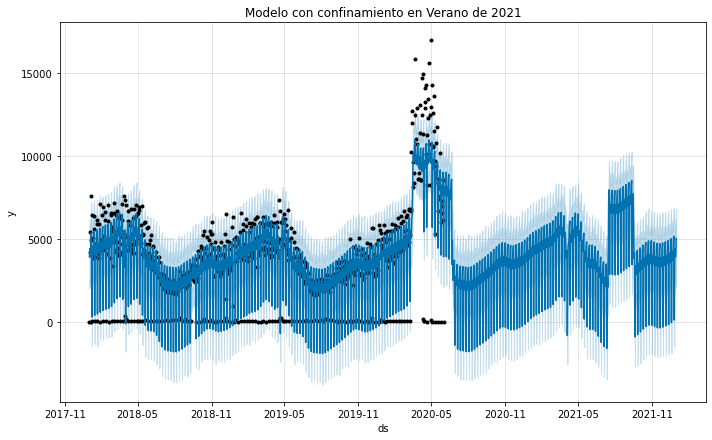

In [160]:
futuro4 = modelo_2021_2.make_future_dataframe(periods=579)
prevision_2021_2 = modelo_2021_2.predict(futuro4)
modelo_2021_2.plot(prevision_2021_2);
plt.gca().set_title('Modelo con confinamiento en Verano de 2021');

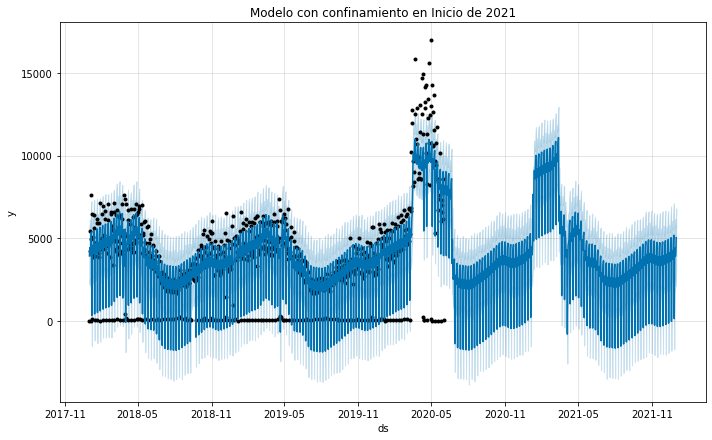

In [159]:
#Modelo con confinamiento en Inicio de 2021
modelo_2021_1.plot(prevision_2021_1);
plt.gca().set_title('Modelo con confinamiento en Inicio de 2021');

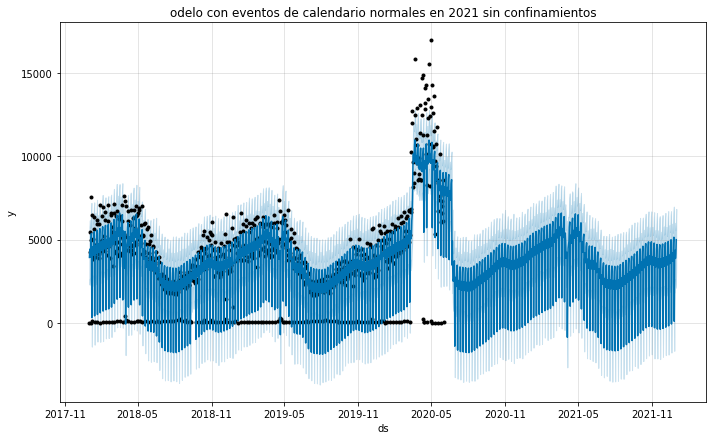

In [161]:
#Modelo con eventos de calendario normales en 2021 sin confinamientos
modelo2.plot(prevision2);
plt.gca().set_title('Modelo con eventos de calendario normales en 2021 sin confinamientos');

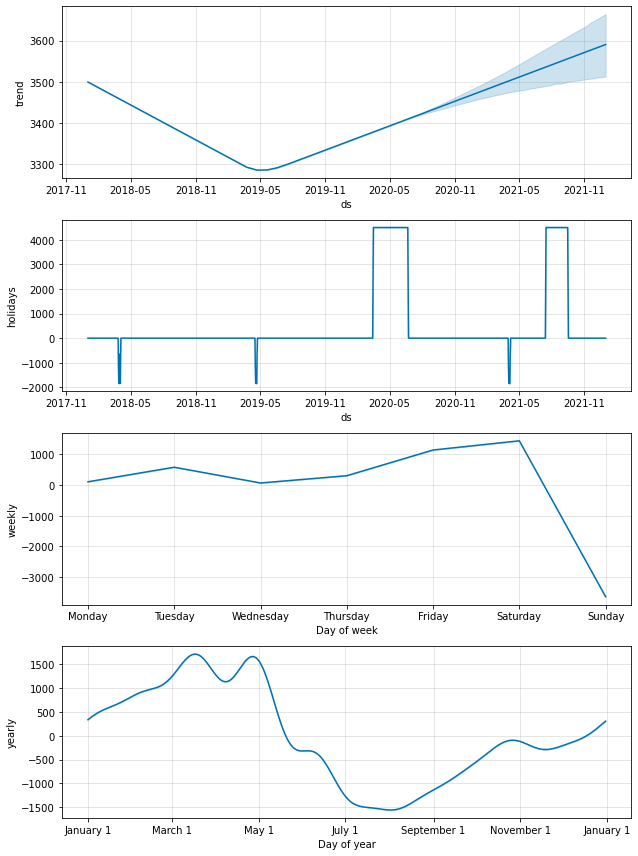

In [162]:
modelo_2021_2.plot_components(prevision_2021_2, weekly_start = 1);

#### Comparativa 2020 vs 2021 Escenario 1: Confinamiento inicio 2021

In [163]:
df_datos_categorias_mejor

,ds,y
0,2018-01-01,1.890000
1,2018-01-02,5454.980826
2,2018-01-03,4249.981477
3,2018-01-04,4981.092628
4,2018-01-05,7594.093859
...,...,...
867,2020-05-27,6586.670017
868,2020-05-28,7026.790011
869,2020-05-29,8565.650021
870,2020-05-30,6147.320011


In [49]:
#Previsión con confinamiento en enero 2021
prevision_2021_1.loc[:,['ds','yhat']]

,ds,yhat
0,2018-01-01,3910.613235
1,2018-01-02,4426.960947
2,2018-01-03,3936.433288
3,2018-01-04,4179.806087
4,2018-01-05,5032.532669
...,...,...
1446,2021-12-27,3874.055833
1447,2021-12-28,4392.275519
1448,2021-12-29,3904.239654
1449,2021-12-30,4150.677413


In [50]:
#Previsión con confinamiento en verano 2021
prevision_2021_2.loc[:,['ds','yhat']]

,ds,yhat
0,2018-01-01,3910.613235
1,2018-01-02,4426.960947
2,2018-01-03,3936.433288
3,2018-01-04,4179.806087
4,2018-01-05,5032.532669
...,...,...
1446,2021-12-27,3874.055833
1447,2021-12-28,4392.275519
1448,2021-12-29,3904.239654
1449,2021-12-30,4150.677413


In [51]:
df_comparativa_nueva=df_datos_categorias_mejor[((df_datos_categorias_mejor['ds'] >= '2019-01-01') &
    (df_datos_categorias_mejor['ds'] <= '2019-05-31'))|((df_datos_categorias_mejor['ds'] >= '2020-01-01') &
    (df_datos_categorias_mejor['ds'] <= '2020-05-31'))]
df_comparativa_nueva = df_comparativa_nueva.rename(columns={'ds': 'Fecha', 'y': 'Ventas'})
df_comparativa_nueva['Categoría']='Frutos secos'

In [52]:
df_comparativa_prophet=prevision_2021_1[((prevision_2021_1['ds'] >= '2021-01-01') &
    (prevision_2021_1['ds'] <= '2021-05-31'))].loc[:,['ds','yhat']]
df_comparativa_prophet = df_comparativa_prophet.rename(columns={'ds': 'Fecha', 'yhat': 'Ventas'})
df_comparativa_prophet['Categoría']='Frutos secos'

In [53]:
#Concatenamos los datos reales de ventas que tenemos hasta 31-Mayo-2020 con los datos estimados por Prophet
#para el mismo periodo en 2021
df_comparativa_nueva_prophet=pd.concat((df_comparativa_nueva,df_comparativa_prophet))

In [54]:
df_comparativa_nueva_prophet

,Fecha,Ventas,Categoría
363,2019-01-02,4174.463691,Frutos secos
364,2019-01-03,3710.051522,Frutos secos
365,2019-01-04,5091.010832,Frutos secos
366,2019-01-05,4869.341939,Frutos secos
367,2019-01-06,10.020003,Frutos secos
...,...,...,...
1232,2021-05-27,3489.462882,Frutos secos
1233,2021-05-28,4306.079784,Frutos secos
1234,2021-05-29,4605.047684,Frutos secos
1235,2021-05-30,-488.454998,Frutos secos


In [55]:
df_comparativa_nueva_prophet_pivot = pd.pivot_table(df_comparativa_nueva_prophet, values='Ventas', index=['Fecha'],
                     columns=['Categoría'],aggfunc='sum',fill_value=0)
df_comparativa_nueva_prophet_pivot=df_comparativa_nueva_prophet_pivot.resample('Q').sum()
#df_categorias_trimestre_pivot.pct_change()
df_comparativa_nueva_prophet_pivot=df_comparativa_nueva_prophet_pivot.apply(calculo_variaciones)
df_comparativa_nueva_prophet_pivot

Categoría,Frutos secos
Fecha,
2019-03-31,NaN
2019-06-30,NaN
2019-09-30,NaN
2019-12-31,NaN
2020-03-31,29.203064
2020-06-30,110.698487
2020-09-30,NaN
2020-12-31,NaN
2021-03-31,-15.105410


In [56]:
df_comparativa_nueva_prophet_definitivo=df_comparativa_nueva_prophet_pivot.T
df_comparativa_nueva_prophet_definitivo

Fecha,2019-03-31,2019-06-30,2019-09-30,2019-12-31,2020-03-31,2020-06-30,2020-09-30,2020-12-31,2021-03-31,2021-06-30
Categoría,,,,,,,,,,
Frutos secos,NaN,NaN,NaN,NaN,29.203064,110.698487,NaN,NaN,-15.10541,-49.819715


In [57]:
df_comparativa_nueva_prophet_definitivo['Q1_20_21']=df_comparativa_nueva_prophet_definitivo.iloc[:,8]
df_comparativa_nueva_prophet_definitivo['Q2_20_21']=df_comparativa_nueva_prophet_definitivo.iloc[:,9]

df_comparativa_nueva_prophet_definitivo=df_comparativa_nueva_prophet_definitivo.loc[:,['Q1_20_21','Q2_20_21']]
df_comparativa_nueva_prophet_definitivo.sort_values(by='Q2_20_21', ascending=False)


Fecha,Q1_20_21,Q2_20_21
Categoría,,
Frutos secos,-15.10541,-49.819715


#### Comparativa 2020 vs 2021 Escenario 2: Confinamiento verano 2021

In [58]:
df_comparativa_2_prophet=prevision_2021_2[((prevision_2021_2['ds'] >= '2021-01-01') &
    (prevision_2021_2['ds'] <= '2021-05-31'))].loc[:,['ds','yhat']]
df_comparativa_2_prophet = df_comparativa_2_prophet.rename(columns={'ds': 'Fecha', 'yhat': 'Ventas'})
df_comparativa_2_prophet['Categoría']='Frutos secos'

In [59]:
#Concatenamos los datos reales de ventas que tenemos hasta 31-Mayo-2020 con los datos estimados por Prophet
#para el mismo periodo en 2021
df_comparativa_nueva_2_prophet=pd.concat((df_comparativa_nueva,df_comparativa_2_prophet))

In [60]:
df_comparativa_nueva_2_prophet

,Fecha,Ventas,Categoría
363,2019-01-02,4174.463691,Frutos secos
364,2019-01-03,3710.051522,Frutos secos
365,2019-01-04,5091.010832,Frutos secos
366,2019-01-05,4869.341939,Frutos secos
367,2019-01-06,10.020003,Frutos secos
...,...,...,...
1232,2021-05-27,3489.462882,Frutos secos
1233,2021-05-28,4306.079784,Frutos secos
1234,2021-05-29,4605.047684,Frutos secos
1235,2021-05-30,-488.454998,Frutos secos


In [61]:
df_comparativa_nueva_2_prophet_pivot = pd.pivot_table(df_comparativa_nueva_2_prophet, values='Ventas', index=['Fecha'],
                     columns=['Categoría'],aggfunc='sum',fill_value=0)
df_comparativa_nueva_2_prophet_pivot=df_comparativa_nueva_2_prophet_pivot.resample('Q').sum()
#df_categorias_trimestre_pivot.pct_change()
df_comparativa_nueva_2_prophet_pivot=df_comparativa_nueva_2_prophet_pivot.apply(calculo_variaciones)
df_comparativa_nueva_2_prophet_pivot

Categoría,Frutos secos
Fecha,
2019-03-31,NaN
2019-06-30,NaN
2019-09-30,NaN
2019-12-31,NaN
2020-03-31,29.203064
2020-06-30,110.698487
2020-09-30,NaN
2020-12-31,NaN
2021-03-31,-15.105410


In [62]:
df_comparativa_nueva_2_prophet_definitivo=df_comparativa_nueva_2_prophet_pivot.T
df_comparativa_nueva_2_prophet_definitivo

Fecha,2019-03-31,2019-06-30,2019-09-30,2019-12-31,2020-03-31,2020-06-30,2020-09-30,2020-12-31,2021-03-31,2021-06-30
Categoría,,,,,,,,,,
Frutos secos,NaN,NaN,NaN,NaN,29.203064,110.698487,NaN,NaN,-15.10541,-49.819715


In [63]:
df_comparativa_nueva_2_prophet_definitivo['Q1_20_21']=df_comparativa_nueva_2_prophet_definitivo.iloc[:,8]
df_comparativa_nueva_2_prophet_definitivo['Q2_20_21']=df_comparativa_nueva_2_prophet_definitivo.iloc[:,9]

df_comparativa_nueva_2_prophet_definitivo=df_comparativa_nueva_2_prophet_definitivo.loc[:,['Q1_20_21','Q2_20_21']]
df_comparativa_nueva_2_prophet_definitivo.sort_values(by='Q2_20_21', ascending=False)


Fecha,Q1_20_21,Q2_20_21
Categoría,,
Frutos secos,-15.10541,-49.819715
